In [118]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss
from numpy.linalg import inv
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [119]:
# read in 4th down decision from 2016-2024
path = "data/decisions_2016_2024.csv"
df = pd.read_csv(path)

In [120]:
actions = ["go", "punt", "fg"]
reward = "epa" # keep as "epa" for EPA notebook, "wpa" for WPA notebook

In [121]:
df = df[df["action"].isin(actions)].copy() # ensure each row is one of the three actions
df

,season,week,game_id,game_date,play_id,posteam,defteam,home_team,away_team,posteam_type,...,play_elapsed_s,game_time_elapsed,def_time_on_field_cum,def_time_on_field_share,is_q4_or_later,action,fg_pct_short,fg_pct_mid,fg_pct_long,punt_net_4w
0,2016,1,2016_01_BUF_BAL,2016-09-11,198.0,BAL,BUF,BAL,BUF,home,...,13.0,188.0,188.0,1.000000,0,punt,0.997562,0.870584,0.704809,-3.899848
1,2016,1,2016_01_BUF_BAL,2016-09-11,285.0,BUF,BAL,BAL,BUF,away,...,33.0,318.0,122.0,0.383648,0,punt,0.950380,0.738880,0.652809,-3.215591
2,2016,1,2016_01_BUF_BAL,2016-09-11,570.0,BUF,BAL,BAL,BUF,away,...,0.0,570.0,212.0,0.371930,0,punt,0.950380,0.738880,0.652809,-3.215591
3,2016,1,2016_01_BUF_BAL,2016-09-11,798.0,BAL,BUF,BAL,BUF,home,...,37.0,859.0,617.0,0.718277,0,fg,0.997562,0.870584,0.704809,-3.899848
4,2016,1,2016_01_BUF_BAL,2016-09-11,986.0,BUF,BAL,BAL,BUF,away,...,35.0,1013.0,360.0,0.355380,0,punt,0.950380,0.738880,0.652809,-3.215591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31844,2024,18,2024_18_WAS_DAL,2025-01-05,2540.0,DAL,WAS,DAL,WAS,home,...,38.0,2165.0,1364.0,0.630023,0,fg,0.833333,0.851852,0.800000,-4.050000
31845,2024,18,2024_18_WAS_DAL,2025-01-05,3299.0,DAL,WAS,DAL,WAS,home,...,4.0,2765.0,1732.0,0.626401,1,fg,0.833333,0.851852,0.800000,-4.050000
31846,2024,18,2024_18_WAS_DAL,2025-01-05,4010.0,WAS,DAL,DAL,WAS,away,...,16.0,3259.0,1115.0,0.342129,1,punt,1.000000,0.909091,0.200000,-4.416667
31847,2024,18,2024_18_WAS_DAL,2025-01-05,4136.0,DAL,WAS,DAL,WAS,home,...,0.0,3395.0,2117.0,0.623564,1,punt,0.833333,0.851852,0.800000,-4.050000


In [122]:
df = df[~df[reward].isna()].copy() # drop rows with missing reward

In [123]:
numeric_candidates = [
    # core context
    'yardline_100','ydstogo','score_differential','qtr','game_seconds_remaining',
    # team strength (rolling averages)
    'off_epa_4w','def_epa_4w',
    # special teams
    'fg_pct_short','fg_pct_mid','fg_pct_long','punt_net_4w',
    # fatigue / drive
    'plays_in_drive_so_far','def_time_on_field_cum','def_time_on_field_share',
    # timeouts
    'home_timeouts_remaining','away_timeouts_remaining',
    'posteam_timeouts_remaining','defteam_timeouts_remaining',
    # weather
    'temp','wind',
    # situational
    'goal_to_go'
]


In [124]:
present_numeric = [c for c in numeric_candidates if c in df.columns] # make sure desired columns are in dataframe

present_numeric

['yardline_100',
 'ydstogo',
 'score_differential',
 'qtr',
 'game_seconds_remaining',
 'off_epa_4w',
 'def_epa_4w',
 'fg_pct_short',
 'fg_pct_mid',
 'fg_pct_long',
 'punt_net_4w',
 'plays_in_drive_so_far',
 'def_time_on_field_cum',
 'def_time_on_field_share',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'temp',
 'wind',
 'goal_to_go']

In [125]:
cat_options = ['posteam','defteam','home_team','away_team',
    'roof','surface']

In [126]:
cat_candidates = [c for c in cat_options if c in df.columns] # make sure desired columns are in dataframe

cat_candidates


['posteam', 'defteam', 'home_team', 'away_team', 'roof', 'surface']

In [127]:
from sklearn.impute import SimpleImputer

feature_cols = present_numeric + cat_candidates
X_raw = df[feature_cols].replace([np.inf, -np.inf], np.nan) # replace inf with nan
y = df["action"] 
r = df[reward].astype(float).to_numpy() # ensure epa is float

mask = y.notna()
X_fit, y_fit = X_raw.loc[mask], y.loc[mask] # only use rows with non-missing action for fitting

num_tf = make_pipeline(SimpleImputer(strategy="median"), StandardScaler()) # transformer

# combine numeric and categorical transformers
transformers = [("num", num_tf, present_numeric)]
if cat_candidates:
    cat_tf = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    )
    transformers.append(("cat", cat_tf, cat_candidates))

pre = ColumnTransformer(transformers=transformers)

In [128]:
# look for missing columns prior to imputation
missing = X_fit.isna().sum()
print("Missing (pre-impute view):")
print(missing[missing > 0])

Missing (pre-impute view):
temp       11046
wind       11046
surface      577
dtype: int64


In [129]:
# build and fit behavior model (logistic regression with preprocessing)
beh_model = make_pipeline(
    pre,
    LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=2000,
        C=1.0
    )
)
beh_model.fit(X_fit, y_fit)

# extract learned classes and predicted probabilities
log_reg = beh_model.named_steps["logisticregression"]
classes = list(log_reg.classes_)
probs = beh_model.predict_proba(X_fit)

# map each action label to its index
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
a_idx = y_fit.map(class_to_idx).to_numpy()

# logged policy probabilities (probability assigned to the taken action)
p_b_logged = probs[np.arange(len(X_fit)), a_idx]

# summary stats
mean_probs = probs.mean(axis=0)
pred_labels = probs.argmax(axis=1)
acc = (pred_labels == a_idx).mean()

print("Classes:", classes)
print("Average action probabilities:",
      dict(zip(classes, np.round(mean_probs, 3))))
print("In-sample accuracy:", round(acc, 3))
print("Logged probs (min / mean / max):",
      np.min(p_b_logged), np.mean(p_b_logged), np.max(p_b_logged))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classes: ['fg', 'go', 'punt']
Average action probabilities: {'fg': 0.263, 'go': 0.178, 'punt': 0.558}
In-sample accuracy: 0.856
Logged probs (min / mean / max): 5.130196364207763e-06 0.785620064352437 0.9999997092393565


Across the plays in the dataset, on average, there's a 26% chance of choosing a field goal, 18% chance going for it, and 56% chance of punting. The model is predicting the observed action about 86% of the time, and the features we're feeding in explain most of the variance in play-calling. The logistic regression behavior model is doing a good job of capturing coaches’ tendencies: it heavily leans toward punting, predicts correctly most of the time, but still shows that once in a while coaches make “surprise” decisions that don’t fit the usual pattern (based on logged probabilities). 

                                   fg        go      punt  importance
num__yardline_100           -2.951752 -0.102685  3.054437    2.036291
num__game_seconds_remaining  0.265991 -1.455860  1.189869    0.970573
num__ydstogo                 0.692056 -1.228480  0.536424    0.818987
num__score_differential      0.202471 -0.649921  0.447450    0.433280
num__def_time_on_field_cum   0.137930 -0.576467  0.438537    0.384311
num__goal_to_go              0.041539  0.528009 -0.569548    0.379699
cat__roof_outdoors          -0.284709 -0.172841  0.457550    0.305033
cat__home_team_BUF          -0.202585 -0.186209  0.388795    0.259196
num__qtr                    -0.036247 -0.348184  0.384431    0.256287
cat__posteam_PHI            -0.116922  0.339396 -0.222474    0.226264


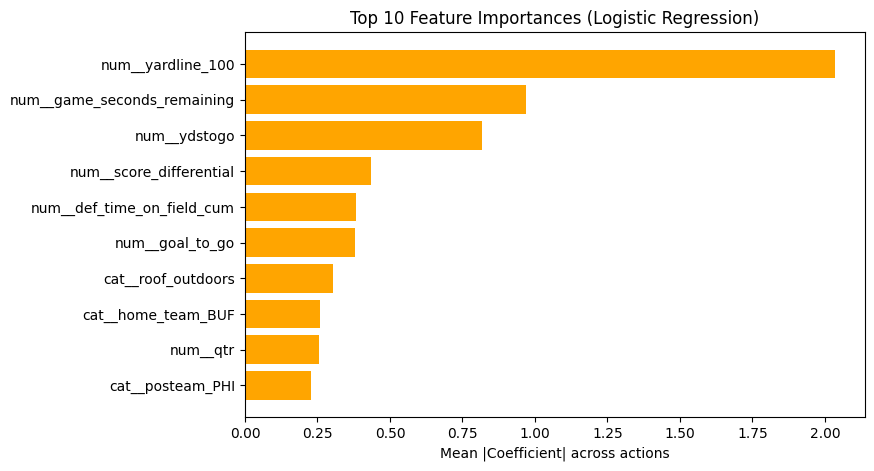

In [130]:
import matplotlib.pyplot as plt

log_reg = beh_model.named_steps["logisticregression"]
feature_names = beh_model.named_steps["columntransformer"].get_feature_names_out()
coefs = log_reg.coef_ # get coeffecients of features to derive feature importance

# Put coefficients into a DataFrame
coef_df = pd.DataFrame(coefs.T, index=feature_names, columns=log_reg.classes_)

# compute importance as mean absolute coefficient across classes
coef_df["importance"] = coef_df.abs().mean(axis=1)

# select top 10
top10 = coef_df.sort_values("importance", ascending=False).head(10)

print(top10)

# plot bar chart
plt.figure(figsize=(8, 5))
plt.barh(top10.index, top10["importance"], color="orange")
plt.xlabel("Mean |Coefficient| across actions")
plt.title("Top 10 Feature Importances (Logistic Regression)")
plt.gca().invert_yaxis()  # highest at top
plt.show()


In [131]:
pre = beh_model.named_steps["columntransformer"]
X_design = pre.transform(X_fit)

In [132]:
arm_models = {} # dictionary to hold models for each action
min_n = 50 # minimum samples to fit linear model
l2 = 5.0 # l2 regularization strength

for a in classes:
    arm_mask = (y_fit == a).to_numpy() # fit separate model for each action
    X_arm = X_design[arm_mask] # design matrix for this action
    y_arm = r_fit[arm_mask] # rewards for this action

    if len(y_arm) < min_n: # not enough samples to fit model
        mu = float(np.mean(y_arm)) if y_arm.size else 0.0 # use mean reward or 0 if no samples
        arm_models[a] = ("const", mu) # store as constant model
    else:
        arm_models[a] = Ridge(alpha=l2, fit_intercept=True).fit(X_arm, y_arm) # fit ridge regression model

In [133]:
# function to predict mu for all actions
def predict_mu_all(Xd):
    N, K = Xd.shape[0], len(classes)
    MU = np.zeros((N, K), dtype=float)
    for j, a in enumerate(classes):
        m = arm_models[a]
        if isinstance(m, tuple) and m[0] == "const":
            MU[:, j] = m[1]
        else:
            MU[:, j] = m.predict(Xd)
    return MU

MU = predict_mu_all(X_design)
N_fit = MU.shape[0] # number of fitted samples

In [134]:
from scipy import sparse

# hyperparameters
alpha = 0.8
lambda_ucb = 5.0

X = X_design # design matrix
N, d = X.shape # number of samples, number of features
K = len(classes) # number of actions

# helper functions
def arm_params(model, d): 
    """Return (intercept, theta, is_const) for an arm model."""
    if isinstance(model, tuple) and model[0] == "const":
        return float(model[1]), np.zeros(d), True
    return float(model.intercept_), model.coef_.reshape(-1), False

def quad_form_rows(X, M):
    """Row-wise quadratic form: diag(X M X^T)."""
    if sparse.issparse(X):
        XM = X @ M
        return np.array(X.multiply(XM).sum(axis=1)).ravel()
    XM = X @ M
    return np.sum(X * XM, axis=1)

# precompute group indices once
idx_by_class = {a: np.where((y_fit == a).to_numpy())[0] for a in classes}

# precompute per-arm params and (X^T X + λI)^(-1)
V_inv, theta, intercepts = {}, {}, {}
for a in classes:
    idx = idx_by_class[a]
    Xa = X[idx]

    b0, th, _ = arm_params(arm_models[a], d)
    intercepts[a], theta[a] = b0, th

    if Xa.shape[0] < d + 1:
        V_inv[a] = np.eye(d) / lambda_ucb
    else:
        XtX = Xa.T @ Xa
        V_inv[a] = inv(XtX + lambda_ucb * np.eye(d))

# greedy direct method
a_star_DM_idx = MU.argmax(axis=1)

# LinUCB scores
scores_ucb = np.empty_like(MU)
for j, a in enumerate(classes):
    mu = X @ theta[a] + intercepts[a]
    quad = quad_form_rows(X, V_inv[a])
    bonus = alpha * np.sqrt(np.maximum(quad, 0.0))
    scores_ucb[:, j] = mu + bonus

a_star_UCB_idx = scores_ucb.argmax(axis=1) # index of chosen action by LinUCB


In [ ]:
# doubly robust off-policy evaluation (OPE) for DM and UCB
# all arrays are length N_fit
p_b_logged_fit = p_b_logged # behavior policy probabilty assigned to action actually take on each play
a_idx_fit = a_idx # index of logged action

def dr_ope(a_star_idx):
    N = N_fit  
    w_ips_num = (a_idx_fit == a_star_idx).astype(float) # 1 if target action == logged action else 0
    w_ips = w_ips_num / np.clip(p_b_logged_fit, 1e-6, 1.0)

    mu_logged = MU[np.arange(N), a_idx_fit] # \hat\mu(x_i, a_i)
    mu_target = MU[np.arange(N), a_star_idx] # \hat\mu(x_i, a^\*_i)

    dr = np.mean(w_ips * (r_fit - mu_logged) + mu_target) # model-based value under target action + a correction using the logged reward and importance weights.
    ips = np.mean(w_ips * r_fit) # pure importance-weighted average of logged rewards

    w_match = w_ips[w_ips_num == 1.0]
    ess = (w_match.sum()**2 / np.sum(w_match**2)) if w_match.size else 0.0 # measures how many independent samples your weights act like
    return float(dr), float(ips), float(ess)

dr_DM, ips_DM, ess_DM = dr_ope(a_star_DM_idx)
dr_UCB, ips_UCB, ess_UCB = dr_ope(a_star_UCB_idx)

In [ ]:
# stochastic: policy does not always pick the same action for a given situation — instead, it assigns probabilities to each action and samples from them.

def dr_ope_stochastic(P_eval):
    """
    Doubly-robust OPE for a *stochastic* target policy.
    P_eval: (N_fit, K) matrix, row i sums to 1, columns align with `classes`.
    Uses p_b_logged_fit, a_idx_fit, r_fit, MU (all length N_fit).
    """
    # logged action prob under eval policy and behavior policy
    pi_e_logged = P_eval[np.arange(N_fit), a_idx_fit]              # (N,)
    w = pi_e_logged / np.clip(p_b_logged_fit, 1e-6, 1.0)           # importance ratio

    mu_logged = MU[np.arange(N_fit), a_idx_fit]                    # (N,)
    mu_target = np.sum(P_eval * MU, axis=1)                        # E_{a~π_e}[μ̂(x,a)]

    dr = np.mean(w * (r_fit - mu_logged) + mu_target)
    ips = np.mean(w * r_fit)
    
    # ESS on rows where pi_e_logged>0
    w_pos = w[pi_e_logged > 0]
    ess = (w_pos.sum()**2) / (np.sum(w_pos**2) + 1e-12) if w_pos.size else 0.0
    return float(dr), float(ips), float(ess)


In [ ]:
# bootstrap: resampling with replacement to get CI around DR estimate
rng = np.random.default_rng(123) # for reproducibility
B = 100 # number of bootstrap samples

def bootstrap_dr(a_star_idx):
    vals = []
    for _ in range(B):
        idx = rng.integers(0, N_fit, size=N_fit)
        w_num_b = (a_idx_fit[idx] == a_star_idx[idx]).astype(float)
        w_b = w_num_b / np.clip(p_b_logged_fit[idx], 1e-6, 1.0) 
        mu_logged_b = MU[idx, a_idx_fit[idx]]
        mu_target_b = MU[idx, a_star_idx[idx]]
        dr_b = np.mean(w_b * (r_fit[idx] - mu_logged_b) + mu_target_b)
        vals.append(dr_b)
    return np.percentile(vals, [2.5, 97.5])

ci_DM = bootstrap_dr(a_star_DM_idx)
ci_UCB = bootstrap_dr(a_star_UCB_idx)

In [153]:
summary = pd.DataFrame({
    "policy": ["Greedy-DM (argmax mu)", "LinUCB (pre-game)"],
    "estimate_DR_EPA": [dr_DM, dr_UCB],
    "DR_95%_CI_low": [ci_DM[0], ci_UCB[0]],
    "DR_95%_CI_high": [ci_DM[1], ci_UCB[1]],
    "IPS_only_EPA": [ips_DM, ips_UCB],
    "IPS_ESS": [ess_DM, ess_UCB],
})

diag_df = pd.DataFrame({
    "metric": (["N_rows_used", "behavior_pred_accuracy", "mean_logged_reward"]
               + [f"p_b_mean_{c}" for c in classes]),
    "value": ([N_fit, float(acc), float(np.mean(r_fit))]
              + [float(p) for p in mean_probs]),
})


In [154]:
summary

,policy,estimate_DR_EPA,DR_95%_CI_low,DR_95%_CI_high,IPS_only_EPA,IPS_ESS
0,Greedy-DM (argmax mu),0.956230,0.501363,1.678831,1.019026,35.463026
1,LinUCB (pre-game),0.944931,0.547020,1.524962,1.030095,31.024205


In [140]:
diag_df

,metric,value
0,N_rows_used,31849.000000
1,behavior_pred_accuracy,0.855882
2,mean_logged_reward,-0.050544
3,p_b_mean_fg,0.263372
4,p_b_mean_go,0.178257
5,p_b_mean_punt,0.558371


Both policies (Greedy and LinUCB) have average expected points added (EPA) close to +1 per decision when evaluated off-policy (re-use old data to simulate what would have happened). This is a big jump compared to the logged mean reward (≈ -0.05 EPA). Suggests that both policies would significantly improve over historical coaching choices.

Greedy-DM: [0.50, 1.68]
LinUCB: [0.55, 1.52]
Both intervals exclude 0, so the improvement is statistically meaningful (at least under the DR estimator).

IPS is similar to DR (~1.0 EPA), but IPS has higher variance; DR is more stable. ESS is much lower than the raw sample size (~31k plays), meaning only ~30 “effective” samples carry the weight (common in bandit/OPE due to reweighting). Still nontrivial, but signals caution about high variance.

Historically, coaches were conservative: more than half of 4th-down plays were punts. Those choices led to a slight negative average EPA (-0.05).
The learned counterfactual policies (Greedy-DM, LinUCB) suggest much higher average EPA (+0.95). Behavior model accuracy (86%) is high, and the OPE results are more credible since the logging policy is well captured.

Big Picture:
The off-policy evaluation says: if teams switched to either a greedy “always pick the action with max predicted reward” policy or a LinUCB exploration-based policy, average EPA on 4th downs could increase by about +1 per play instead of slightly negative. Both strategies look statistically better than the status quo, though variance (ESS ~30) means the estimates aren’t ultra-precise.

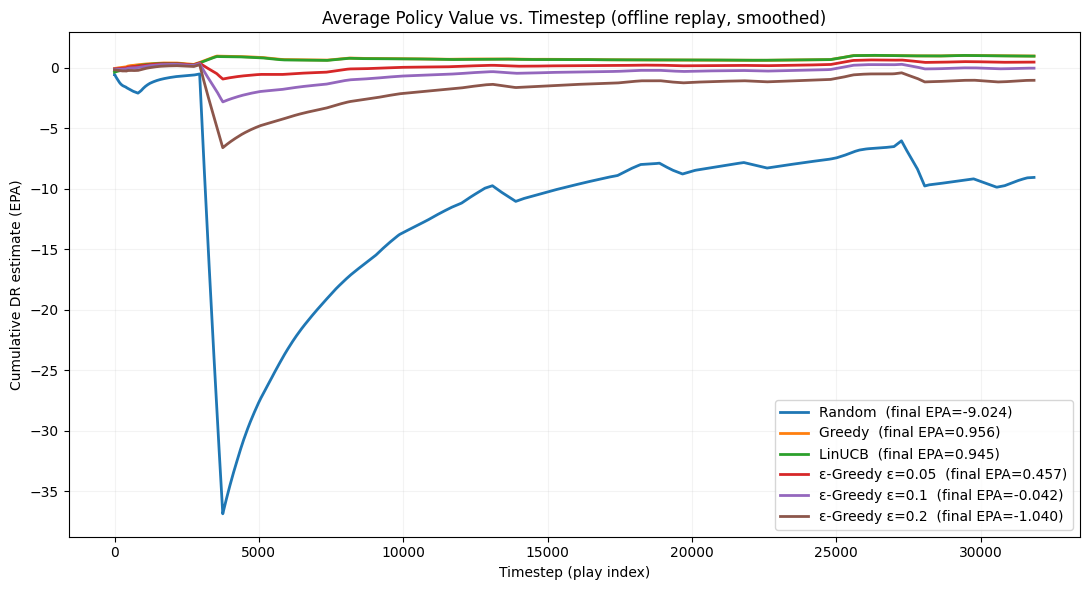

In [ ]:
import matplotlib.pyplot as plt

def dr_per_row_det(a_star_idx, MU, r, a_log, p_b):
    N = len(r)
    w_num = (a_log == a_star_idx).astype(float)
    w = w_num / np.clip(p_b, 1e-6, 1.0)
    mu_log = MU[np.arange(N), a_log]
    mu_tgt = MU[np.arange(N), a_star_idx]
    return w * (r - mu_log) + mu_tgt

def dr_per_row_sto(Pi_e, MU, r, a_log, p_b):
    N = len(r)
    pi_e_logged = Pi_e[np.arange(N), a_log]
    w = pi_e_logged / np.clip(p_b, 1e-6, 1.0)
    mu_log = MU[np.arange(N), a_log]
    mu_tgt = np.sum(Pi_e * MU, axis=1)
    return w * (r - mu_log) + mu_tgt

def pi_random(N, K):
    return np.full((N, K), 1.0 / K, dtype=float)

def pi_epsgreedy(MU, epsilon=0.1):
    N, K = MU.shape
    Pi = np.full((N, K), epsilon / K, dtype=float)
    g = MU.argmax(axis=1)
    Pi[np.arange(N), g] += (1.0 - epsilon)
    return Pi

def cummean(x):
    return np.cumsum(x) / np.arange(1, len(x) + 1)

def smooth(y, win=501):
    """Centered rolling mean; falls back if series shorter than window."""
    win = min(win, max(3, (len(y)//20)*2+1))  # odd window; ~5% of series if long
    return pd.Series(y).rolling(win, center=True, min_periods=1).mean().to_numpy()

def plot_policy_learning_curves(
    MU, r_fit, a_idx_fit, p_b_logged_fit, a_star_DM_idx, a_star_UCB_idx,
    ylabel="EPA", shuffle=True, seed=0, smooth_win=501, show_random=True
):
    rng = np.random.default_rng(seed)
    N, K = MU.shape
    order = rng.permutation(N) if shuffle else np.arange(N)

    psi_greedy = dr_per_row_det(a_star_DM_idx, MU, r_fit, a_idx_fit, p_b_logged_fit)[order]
    psi_ucb    = dr_per_row_det(a_star_UCB_idx, MU, r_fit, a_idx_fit, p_b_logged_fit)[order]

    curves = {}
    if show_random:
        psi_rand = dr_per_row_sto(pi_random(N, K), MU, r_fit, a_idx_fit, p_b_logged_fit)[order]
        curves["Random"] = cummean(psi_rand)

    curves["Greedy"] = cummean(psi_greedy)
    curves["LinUCB"] = cummean(psi_ucb)

    for eps in [0.05, 0.10, 0.20]:
        Pi = pi_epsgreedy(MU, epsilon=eps)
        psi_eps = dr_per_row_sto(Pi, MU, r_fit, a_idx_fit, p_b_logged_fit)[order]
        curves[f"ε-Greedy ε={eps:g}"] = cummean(psi_eps)

    # Smooth & collect terminal values
    curves_s = {k: smooth(v, win=smooth_win) for k, v in curves.items()}
    finals = {k: float(v[-1]) for k, v in curves.items()}

    plt.figure(figsize=(11,6))
    for name, y in curves_s.items():
        lab = f"{name}  (final {ylabel}={finals[name]:.3f})"
        plt.plot(y, label=lab, linewidth=2)

    plt.xlabel("Timestep (play index)")
    plt.ylabel(f"Cumulative DR estimate ({ylabel})")
    plt.title(f"Average Policy Value vs. Timestep (offline replay, smoothed)")
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.15)
    plt.tight_layout()
    plt.show()

    return finals

finals_epa = plot_policy_learning_curves(MU, r_fit, a_idx_fit, p_b_logged_fit,
                                          a_star_DM_idx, a_star_UCB_idx,
                                          ylabel="EPA", shuffle=True, seed=7, smooth_win=801)


Greedy and LinUCB show ~+1 EPA/play vs logged behavior (which was slightly negative in earlier tables).
Exploration hurts in offline replay: ε-greedy policies deteriorate as ε increases, because randomness injects bad choices.
Greedy ≈ LinUCB: In this offline dataset, simply choosing the best predicted action is just as good as adding confidence-bound exploration.

In [ ]:
dr_eq, ips_eq, ess_eq = dr_ope_stochastic(P_b)
print("DR(π_e = π_b) =", dr_eq, "  mean_logged_reward =", r_fit.mean()) 
# make sure these two numbers are very close because the doubly robust estimate should equal the mean logged reward when the evaluation policy equals the behavior policy

DR(π_e = π_b) = -0.05053035716597362   mean_logged_reward = -0.050543926124687055


In [ ]:
epa_by_action = (
    df.groupby("action")["epa"]
      .agg(["count", "mean", "std", "min", "max"])
      .reset_index()
)

print(epa_by_action)

# sort by mean EPA to see which action looks best on average
epa_by_action.sort_values("mean", ascending=False)

  action  count      mean       std        min       max
0     fg   8388  0.053387  1.563120  -9.964310  3.524636
1     go   5678  0.053588  2.961502 -11.448006  8.043193
2   punt  17783 -0.132815  0.957115  -7.345287  8.227220


,action,count,mean,std,min,max
1,go,5678,0.053588,2.961502,-11.448006,8.043193
0,fg,8388,0.053387,1.563120,-9.964310,3.524636
2,punt,17783,-0.132815,0.957115,-7.345287,8.227220


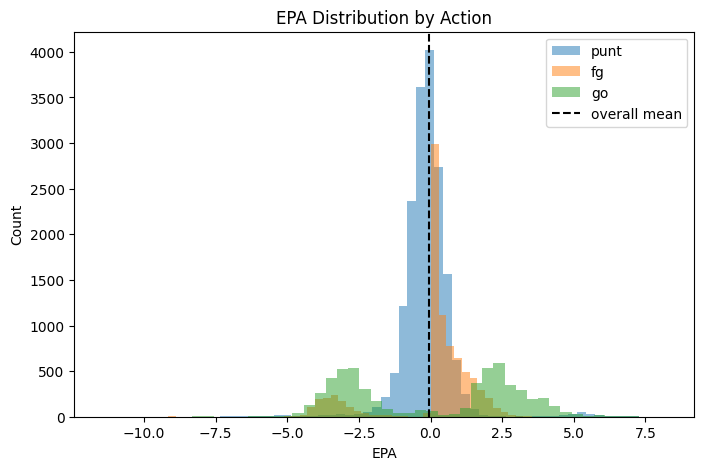

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for a in df["action"].unique():
    subset = df.loc[df["action"] == a, "epa"]
    plt.hist(subset, bins=50, alpha=0.5, label=a)
plt.axvline(df["epa"].mean(), color="k", linestyle="--", label="overall mean")
plt.xlabel("EPA")
plt.ylabel("Count")
plt.title("EPA Distribution by Action")
plt.legend()
plt.show()


In [155]:
# bin yardline into field zones (e.g. red zone, midfield, own territory)
df['yardline_bin'] = pd.cut(
    df['yardline_100'],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["Red Zone (0-20)", "Opp 20-40", "Midfield (40-60)", "Own 40-20", "Own 20+"]
)

epa_by_yardline = (
    df.groupby(['yardline_bin', 'action'])['epa']
      .agg(['count', 'mean'])
      .reset_index()
      .sort_values(['yardline_bin','action'])
)

print(epa_by_yardline)


        yardline_bin action  count      mean
0    Red Zone (0-20)     fg   4241  0.008068
1    Red Zone (0-20)     go   1417 -0.178346
2    Red Zone (0-20)   punt      0       NaN
3          Opp 20-40     fg   4098  0.100926
4          Opp 20-40     go   1759  0.008281
5          Opp 20-40   punt    538 -0.569908
6   Midfield (40-60)     fg     49 -0.000071
7   Midfield (40-60)     go   1600  0.394744
8   Midfield (40-60)   punt   6035 -0.169821
9          Own 40-20     fg      0       NaN
10         Own 40-20     go    789  0.043128
11         Own 40-20   punt   8644 -0.069112
12           Own 20+     fg      0       NaN
13           Own 20+     go    113 -1.090245
14           Own 20+   punt   2566 -0.168732


In [156]:
df['ydstogo_bin'] = pd.cut(
    df['ydstogo'],
    bins=[0, 2, 5, 10, 20, 100],
    labels=["1-2", "3-5", "6-10", "11-20", "20+"]
)

epa_by_ydstogo = (
    df.groupby(['ydstogo_bin','action'])['epa']
      .agg(['count','mean'])
      .reset_index()
      .sort_values(['ydstogo_bin','action'])
)

print(epa_by_ydstogo)


   ydstogo_bin action  count      mean
0          1-2     fg    961  0.049541
1          1-2     go   3038  0.317186
2          1-2   punt   2113 -0.386676
3          3-5     fg   2376  0.025491
4          3-5     go   1253  0.146421
5          3-5   punt   3676 -0.214947
6         6-10     fg   3270  0.077067
7         6-10     go    920 -0.402676
8         6-10   punt   6299 -0.113161
9        11-20     fg   1634  0.046264
10       11-20     go    402 -0.946915
11       11-20   punt   4872  0.003906
12         20+     fg    147  0.081813
13         20+     go     65 -1.410538
14         20+   punt    823 -0.073982


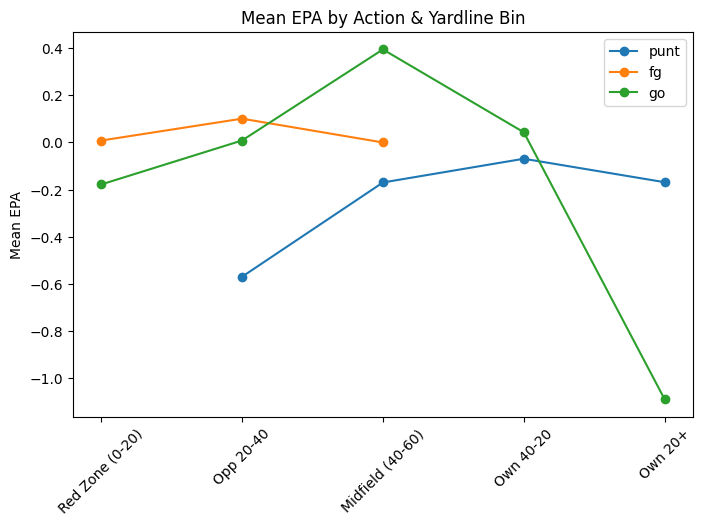

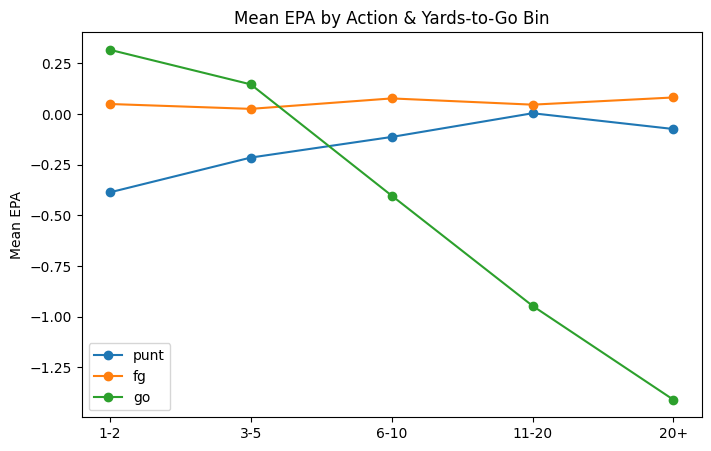

In [158]:
# yardline plot
plt.figure(figsize=(8,5))
for a in df['action'].unique():
    subset = df.groupby('yardline_bin')['epa'].mean().reset_index()
    plt.plot(
        epa_by_yardline.loc[epa_by_yardline['action']==a,'yardline_bin'],
        epa_by_yardline.loc[epa_by_yardline['action']==a,'mean'],
        marker='o', label=a
    )
plt.xticks(rotation=45)
plt.ylabel("Mean EPA")
plt.title("Mean EPA by Action & Yardline Bin")
plt.legend()
plt.show()

# yards-to-go plot
plt.figure(figsize=(8,5))
for a in df['action'].unique():
    plt.plot(
        epa_by_ydstogo.loc[epa_by_ydstogo['action']==a,'ydstogo_bin'],
        epa_by_ydstogo.loc[epa_by_ydstogo['action']==a,'mean'],
        marker='o', label=a
    )
plt.ylabel("Mean EPA")
plt.title("Mean EPA by Action & Yards-to-Go Bin")
plt.legend()
plt.show()


In [159]:
# group mean EPA by yardline bin & action
epa_by_yardline = (
    df.groupby(['yardline_bin','action'])['epa']
      .mean().unstack()
)

# compute ΔEPA of go vs best alternative
epa_by_yardline['best_alt'] = epa_by_yardline[['fg','punt']].max(axis=1)
epa_by_yardline['delta_go'] = epa_by_yardline['go'] - epa_by_yardline['best_alt']

print("Decision table by yardline:")
print(epa_by_yardline[['fg','punt','go','best_alt','delta_go']])


Decision table by yardline:
action                  fg      punt        go  best_alt  delta_go
yardline_bin                                                      
Red Zone (0-20)   0.008068       NaN -0.178346  0.008068 -0.186414
Opp 20-40         0.100926 -0.569908  0.008281  0.100926 -0.092645
Midfield (40-60) -0.000071 -0.169821  0.394744 -0.000071  0.394815
Own 40-20              NaN -0.069112  0.043128 -0.069112  0.112240
Own 20+                NaN -0.168732 -1.090245 -0.168732 -0.921512


In [149]:
epa_by_ydstogo = (
    df.groupby(['ydstogo_bin','action'])['epa']
      .mean().unstack()
)

epa_by_ydstogo['best_alt'] = epa_by_ydstogo[['fg','punt']].max(axis=1)
epa_by_ydstogo['delta_go'] = epa_by_ydstogo['go'] - epa_by_ydstogo['best_alt']

print("Decision table by ydstogo:")
print(epa_by_ydstogo[['fg','punt','go','best_alt','delta_go']])


Decision table by ydstogo:
action             fg      punt        go  best_alt  delta_go
ydstogo_bin                                                  
1-2          0.049541 -0.386676  0.317186  0.049541  0.267645
3-5          0.025491 -0.214947  0.146421  0.025491  0.120930
6-10         0.077067 -0.113161 -0.402676  0.077067 -0.479743
11-20        0.046264  0.003906 -0.946915  0.046264 -0.993179
20+          0.081813 -0.073982 -1.410538  0.081813 -1.492351


In [160]:
import os, json, joblib

os.makedirs("artifacts", exist_ok=True)

# actions (keep exact order used in training)
ACTIONS = list(classes)
assert set(ACTIONS) == {"go","punt","fg"}

# save the shared, **fit** preprocessor (ok to overwrite; same in both nbs)
pre = beh_model.named_steps["columntransformer"]
joblib.dump(pre, "artifacts/preprocessor.joblib", compress=3)

# save EPA per-arm models
arm_models_epa = arm_models   # your trained dict
joblib.dump(arm_models_epa, "artifacts/arm_models_epa.joblib", compress=3)

# save shared metadata (feature lists + action order) — reward-agnostic
numeric_candidates = [
    "yardline_100","ydstogo","score_differential","qtr","game_seconds_remaining",
    "off_epa_4w","def_epa_4w","fg_pct_short","fg_pct_mid","fg_pct_long","punt_net_4w",
    "plays_in_drive_so_far","def_time_on_field_cum","def_time_on_field_share",
    "home_timeouts_remaining","away_timeouts_remaining",
    "posteam_timeouts_remaining","defteam_timeouts_remaining",
    "temp","wind"
]

categorical_candidates = [
    "posteam","defteam","home_team","away_team",
    "posteam_type","roof","surface","goal_to_go"
]

meta = {
    "actions": ACTIONS,
    "numeric_features": numeric_candidates,
    "categorical_features": categorical_candidates,
    "feature_cols": numeric_candidates + categorical_candidates
}
with open("artifacts/metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

print("EPA artifacts saved:", os.listdir("artifacts"))


EPA artifacts saved: ['arm_models_wpa.joblib', 'test_infer.py', 'preprocessor.joblib', 'arm_models_epa.joblib', 'metadata.json', '__pycache__', 'inference.py']
